在实现tensorflow直接读取图像的时候发现如下有趣的现象：
对于手机、相机等设备拍摄的照片，由于手持方向的不同，拍出来的照片可能是旋转0°、90°、180°和270°。即使在电脑上利用软件将其转正，他们的exif信息中还是会保留方位信息，在用PIL读取这些图像时，读取的是原始数据，也就是说，即使电脑屏幕上显示是正常的照片，用PIL读进来后，也可能是旋转的图像，并且图片的size也可能与屏幕上的不一样。使用tensorflow的tf.image.decode_jpeg函数也会发生类似的自动翻转，解决办法就是使用opencv读取可以避免上述情况的发生,但是有的时候，使用tf.data构建input pipline时候遇到的问题.

Instructions for updating:
Use tf.gfile.GFile.
Tensor("PyFunc:1", dtype=int64)


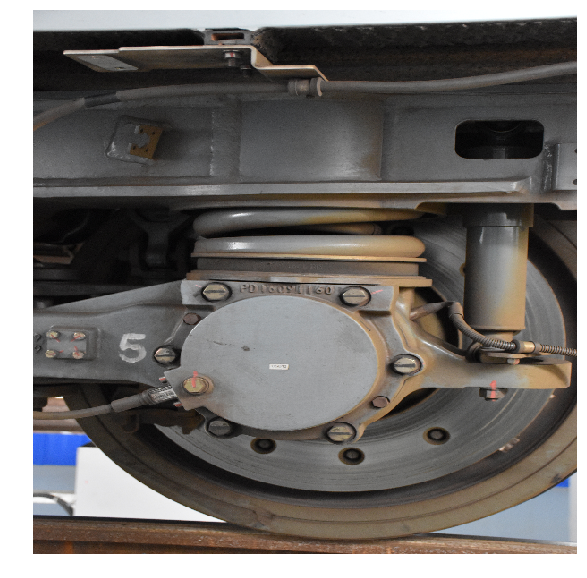

[6000 4000    3]


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

sess = tf.Session()
# 使用tf.py_func函数输出输出必须是numpy类型的数据，适应tf中的tensor，所以im_shape必须处理成numpy格式
def decode_image(image):
    image = cv2.cvtColor(cv2.imdecode(image, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
    im_shape = np.array(image.shape)
    return image, im_shape

image_path = './demo.JPG'

image = tf.gfile.FastGFile(image_path,'rb').read()
# opencv的imdecode需要的格式unit8，这里需要转成uint8
image = tf.decode_raw(image,tf.uint8)
# 关于tf.py_func函数，如果Tout的类型设置的不对，会出现问题
# im_shape在windows上默认的是np.int32，在linux上默认是np.int64，所以decode_image需要加上类型
image,im_shape = tf.py_func(decode_image,inp=[image], Tout=[tf.uint8,tf.int64])
print(im_shape)

#  如果不加这句，下面resize会出现image no shape
image = tf.reshape(image,[im_shape[0],im_shape[1], 3])

# 实验发现，convert_image_dtye会将[0,255]转换成[0.,1.]
# 不加这行代码，不能使用plt正确显示，
# 不加，正常放缩只是[0,255]的浮点数
image = tf.image.convert_image_dtype(image,dtype=tf.float32)
image = tf.image.resize_images(image,(608,608))

img = sess.run(image)
fig = plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.show()
sh = sess.run(im_shape)
print(sh)